Stephanie Chiang
DATA 620 Summer 2025
Final Project
# Last Words
### An Analysis of the Final Statements of Death Row Inmates Using Natural Language Processing

### Introduction

This project aims to examine the “last words” of death row inmates by using their official final statements, as published on the [Texas Department of Criminal Justice website](https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html).

My interest is in trying to understand what people facing the end of their lives think and feel. This type of data is almost impossible (and perhaps ethically dubious) to collect systematically from the general population. However, inmates in Texas facing execution are given the chance to make final statements, which have been collected since at least 1982. I plan to use this publicly available data to explore the language of last statements for any patterns which may reveal insights into emotional states and common themes. And I aim to do so with sensitivity and respect for the individuals involved.

Using NLP, I goal is to be able to illuminate what people feel, think and value when death is imminent. This is a universal human experience and my hope that this information would be helpful to any others facing the same; in effect, this is all of us, just on different time scales.

### Data Collection

The data is collected from the Texas Department of Criminal Justice website, which provides a list of death row inmates and their last statements. The scraping process involves:
1. Fetching the main page containing individual inmate data and links to last statement pages.
2. Extracting the URL of each inmate's page.
3. Visiting each link to scrape the inmate's last statement.
4. Storing the data in a structured format for analysis.

I will use the Beautiful Soup library to parse the HTML and extract the relevant information. The final dataset will include the inmate's name, last statement, and some demographic details.

In [27]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Step 1: Get the main page table and parse
base_url = "https://www.tdcj.texas.gov"
table_url = urljoin(base_url, "/death_row/dr_executed_offenders.html")

response = requests.get(table_url, verify=False)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

# Step 2: Extract the links from the 3rd column and other relevant data
links = []

for row in soup.find_all("tr"):
    cells = row.find_all("td")
    if cells:
        id = cells[0].get_text(strip=True)
        last_name = cells[3].get_text(strip=True)
        first_name = cells[4].get_text(strip=True)
        age = cells[6].get_text(strip=True)
        date = cells[7].get_text(strip=True)
        race = cells[8].get_text(strip=True)

        link_tag = cells[2].find("a")
        slug = link_tag.get("href")

        # Skip rows with no last statement
        if "no_last_statement" in slug:
            continue
        # Ensure slugs are correctly formatted
        if slug and not slug.startswith("/death_row/"):
            slug = "/death_row/" + slug
        # Construct a row in the draft data
        if link_tag and slug:
            href = urljoin(base_url, slug)
            links.append([id, last_name, first_name, age, date, race, href])

print(f"Found {len(links)} links.")

Found 493 links.


In [28]:
# Step 3: Visit each link, parse and scrape data
scraped_data = []

for row in links:
    url = row[-1]
    try:
        page_response = requests.get(url, verify=False)
        page_response.raise_for_status()
        page_soup = BeautifulSoup(page_response.text, "html.parser")

        statement = page_soup.find_all("p")[5].get_text(strip=True) if page_soup.find("p") else "NA"
        scraped_data.append(row + [statement])
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")

print(f"Scraped {len(scraped_data)} rows.")

Failed to scrape https://www.tdcj.texas.gov/death_row/dr_info/bibledannylast.html: list index out of range
Scraped 492 rows.


The above scraping took about 2 minutes and resulted in 1 error, due to a page layout issue. A quick check confirms there is no recorded statement for this person, so we can proceed without this row.

Below, the data is recorded as a CSV before proceeding to analysis.

In [80]:
import csv

csv_filename = "dr_scraped.csv"

with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id", "last_name", "first_name", "age", "date", "race", "url", "statement"])
    writer.writerows(scraped_data)

print(f"Saved to '{csv_filename}'")

Saved to 'dr_scraped.csv'


### Exploratory Data Analysis

First, we will clean the data so that some of the demographic details can be visualized. I want to paint the fullest possible picture of the people whose statements are being examined.

In [69]:
import pandas as pd

# Convert to pandas dataframe for analysis
dr_df = pd.DataFrame(scraped_data, columns=["id", "last_name", "first_name", "age", "date", "race", "url", "statement"])

# Convert 'id' and 'age' to integer
dr_df['id'] = pd.to_numeric(dr_df['id'], errors='coerce')
dr_df['age'] = pd.to_numeric(dr_df['age'], errors='coerce')

# Convert 'race' to categorical and check levels
dr_df['race'] = dr_df['race'].astype('category')
print(dr_df['race'].cat.categories.tolist())

# Convert 'date' to datetime
dr_df['date'] = pd.to_datetime(dr_df['date'], errors='coerce')

print(dr_df.info())

['Black', 'Hispanic', 'Other', 'White']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          492 non-null    int64         
 1   last_name   492 non-null    object        
 2   first_name  492 non-null    object        
 3   age         492 non-null    int64         
 4   date        492 non-null    datetime64[ns]
 5   race        492 non-null    category      
 6   url         492 non-null    object        
 7   statement   492 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 27.7+ KB
None


In [70]:
# Drop rows with missing statements
missing1 = dr_df[dr_df['statement'].str.contains("no last statement|no statement", case=False, na=False)].index
dr_df = dr_df.drop(missing1)

missing2 = dr_df[dr_df['statement'] == "None"].index
dr_df = dr_df.drop(missing2)

missing3 = dr_df[dr_df['statement'] == "None."].index
dr_df = dr_df.drop(missing3)

print(dr_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 0 to 491
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          484 non-null    int64         
 1   last_name   484 non-null    object        
 2   first_name  484 non-null    object        
 3   age         484 non-null    int64         
 4   date        484 non-null    datetime64[ns]
 5   race        484 non-null    category      
 6   url         484 non-null    object        
 7   statement   484 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 30.9+ KB
None


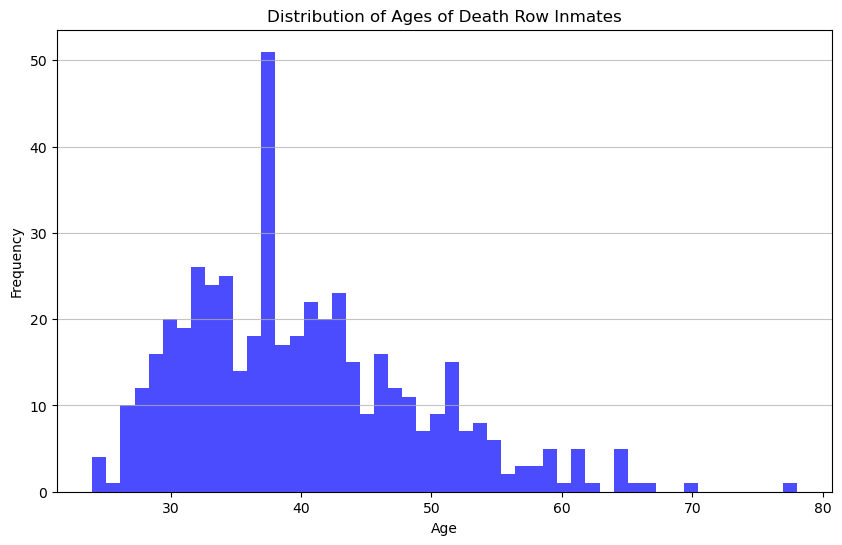

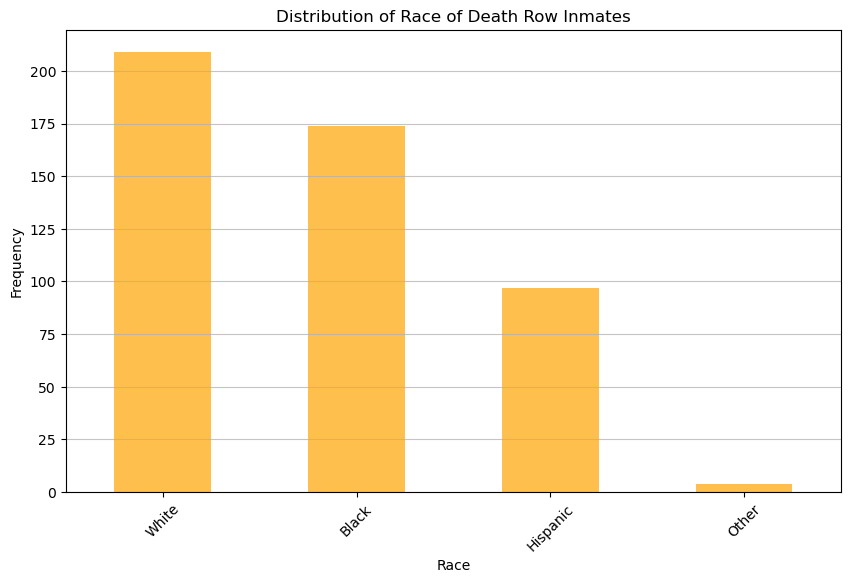

In [87]:
import matplotlib.pyplot as plt

# Plot the distribution of ages
plt.figure(figsize=(10, 6))
plt.hist(dr_df['age'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Ages of Death Row Inmates')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the distribution of race
plt.figure(figsize=(10, 6))
dr_df['race'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Distribution of Race of Death Row Inmates')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

In the age data, there is a clear peak just under 40. Most of the inmates were in the 30s to mid-40s range.

<Figure size 1200x600 with 0 Axes>

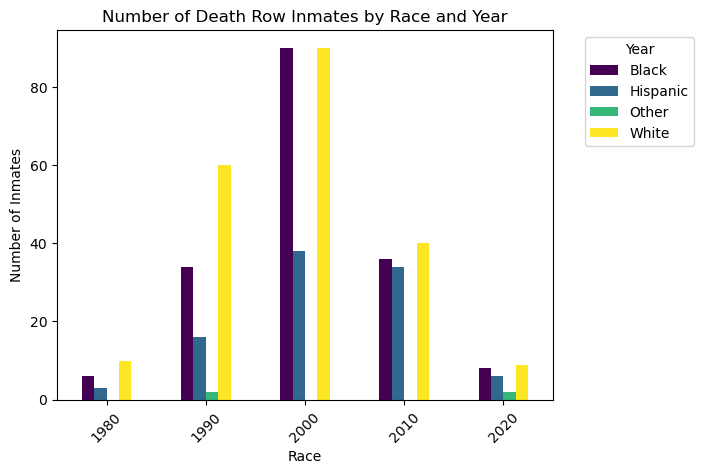

In [88]:
# Group by race and plot by decade
dr_df['decade'] = (dr_df['date'].dt.year // 10) * 10

plt.figure(figsize=(12, 6))
dr_df.groupby(['decade', 'race'], observed=True).size().unstack().plot(kind='bar', colormap='viridis')
plt.title('Number of Death Row Inmates by Race and Year')
plt.xlabel('Race')
plt.ylabel('Number of Inmates')
plt.xticks(rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Natural Language Processing

I will use the NLTK library to perform language processing and sentiment analysis.

In [ ]:
# Plot the distribution of last statement lengths
dr_df['statement_length'] = dr_df['statement'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(dr_df['statement_length'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Last Statement Lengths')
plt.xlabel('Number of Words in Last Statement')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()